In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor

## Energy Consumption Dataset
The following dataset contains synthetic data representing energy consumption patterns for 5,000 customers across different regions. The data includes both residential and commercial properties, with information about building characteristics, occupancy, and monthly energy costs.

Energy consumption analysis is crucial for understanding customer behavior, optimizing resource allocation, and developing targeted energy efficiency programs. This dataset provides a foundation for exploring relationships between building size, occupancy, geographic location, and energy costs.

The dataset includes the following features:

- **customer_id**: Unique identifier for each customer (CUSTOMER_0001 to CUSTOMER_5000)
- **customer_type**: Type of property (residential or commercial)
- **regions**: Geographic region (North, Northeast, Midwest, Southeast, South)
- **building_size_m2**: Building size in square meters (17, 24, 45, 52, or 77 m²)
- **num_residents**: Number of occupants in the property (1-4)
- **energy_cost_brl**: Monthly energy cost in local currency

In this notebook the dataset is used for **predictive modeling of energy costs**.

In [188]:
df = pd.read_csv('exercises/data/energy_consumption.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       5000 non-null   object 
 1   customer_type     5000 non-null   object 
 2   regions           5000 non-null   object 
 3   building_size_m2  5000 non-null   int64  
 4   occupants         5000 non-null   int64  
 5   energy_cost_brl   5000 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 234.5+ KB


In [33]:
df.head(10)
df.describe()

,building_size_m2,occupants,energy_cost_brl
count,5000.00000,5000.000000,5000.000000
mean,39.57620,2.301800,86.874028
std,17.51638,1.032729,24.383261
min,17.00000,1.000000,52.520000
25%,24.00000,1.000000,68.557500
50%,45.00000,2.000000,83.715000
75%,45.00000,3.000000,98.242500
max,77.00000,4.000000,158.610000


<AxesSubplot:xlabel='regions', ylabel='count'>

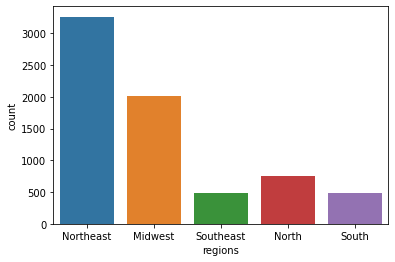

In [41]:
sns.histplot(df['energy_cost_brl'], kde=True)
sns.countplot(x='customer_type', data=df)
sns.countplot(x='regions', data=df)

<AxesSubplot:xlabel='customer_type', ylabel='energy_cost_brl'>

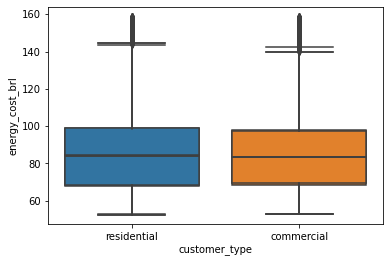

In [46]:
sns.boxplot(x='customer_type', y='energy_cost_brl', data=df)
sns.boxplot(x='regions', y='energy_cost_brl', data=df)

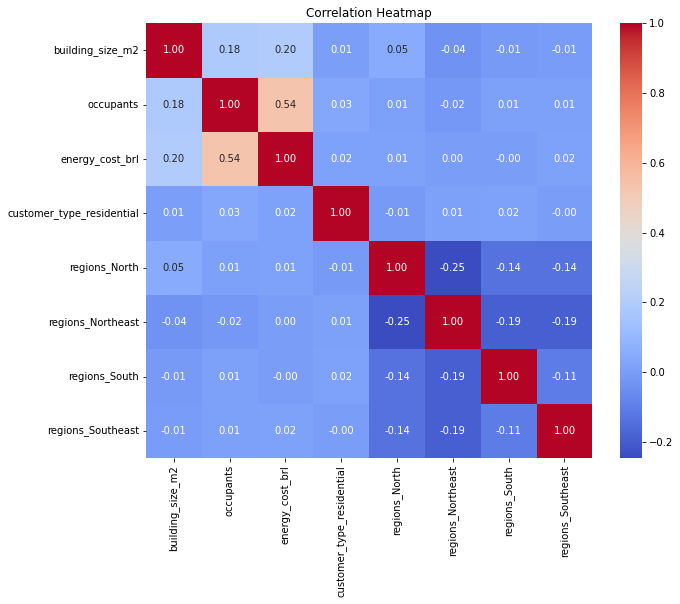

In [48]:
df_encoded = pd.get_dummies(df[['customer_type', 'regions', 'building_size_m2', 'occupants', 'energy_cost_brl']], drop_first=True)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## Preprocessing

In [55]:
features = ['customer_type', 'regions', 'building_size_m2', 'occupants']
obj = ['energy_cost_brl']

numerical_features = ['building_size_m2', 'occupants']
categorical_features = ['customer_type', 'regions']

X = df[features]
y = df[obj]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# standard scaler for numerical features
standard_scaler = StandardScaler()

standard_scaler.fit(X_train[numerical_features])
X_train[numerical_features] = standard_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = standard_scaler.transform(X_test[numerical_features])

# one-hot encoding for categorical features
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

## Predictive Models

### Linear Regressor

In [75]:
reg = LinearRegression()
reg.fit(X_train, y_train)
r2_lin = reg.score(X_test, y_test) #score is the R^2 score

In [83]:
y_pred = reg.predict(X_test)

# error metrics
rmse_lin = mean_squared_error(y_test, y_pred, squared=False)
r2_lin = r2_score(y_test.values.ravel(), y_pred)

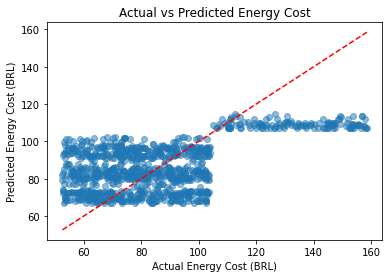

In [78]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("Actual Energy Cost (BRL)")
plt.ylabel("Predicted Energy Cost (BRL)")
plt.title("Actual vs Predicted Energy Cost")
plt.show()

### Random Forest

In [91]:
rf = RandomForestRegressor(
    n_estimators=200,        
    max_depth=None,          
    random_state=42,
    n_jobs=-1         
)

# flat y values to fit random forest 
y_train_flat = y_train.values.ravel()
y_test_flat = y_test.values.ravel()

rf.fit(X_train, y_train_flat)
y_pred_rf = rf.predict(X_test)

# error metrics
rmse_rf = mean_squared_error(y_test_flat, y_pred_rf, squared=False)
r2_rf = r2_score(y_test_flat, y_pred_rf)

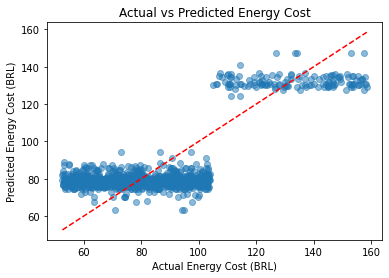

In [96]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("Actual Energy Cost (BRL)")
plt.ylabel("Predicted Energy Cost (BRL)")
plt.title("Actual vs Predicted Energy Cost")
plt.show()

In [136]:
### RF with Grid Search

In [143]:
# grid search to find best hyperparameters
# rf.get_params()
rf_gs = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10],  
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']     
}

grid_search = GridSearchCV(
    estimator=rf_gs,
    param_grid=param_grid,
    cv=3,                  
    n_jobs=-1,             
    scoring='r2',         
)

In [144]:
grid_search.fit(X_train, y_train_flat)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='r2')

In [145]:
grid_search.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [146]:
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# error metrics
rmse_rf_gs = mean_squared_error(y_test_flat, y_pred_best, squared=False)
r2_rf_gs = r2_score(y_test, y_pred_best)

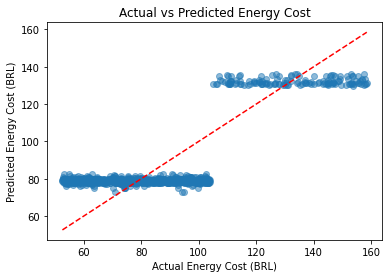

In [147]:
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("Actual Energy Cost (BRL)")
plt.ylabel("Predicted Energy Cost (BRL)")
plt.title("Actual vs Predicted Energy Cost")
plt.show()

### Gradient Boosting

In [148]:
gb = GradientBoostingRegressor(
    n_estimators=200,      
    learning_rate=0.1,     
    max_depth=3,          
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

gb.fit(X_train, y_train_flat)
y_pred_gb = gb.predict(X_test)

rmse_gb = mean_squared_error(y_test_flat, y_pred_gb, squared=False)
r2_gb = r2_score(y_test_flat, y_pred_gb)

In [150]:
### GB with grid search

In [155]:
param_grid_gb = {
    'n_estimators': [100, 150, 200, 250],         
    'learning_rate': [0.05, 0.1, 0.2],  
    'max_depth': [None, 5, 10],                  
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=3,
    n_jobs=-1,
    scoring='r2'
)

grid_search_gb.fit(X_train, y_train_flat)

best_gb = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb.predict(X_test)

rmse_best_gb = mean_squared_error(y_test_flat, y_pred_best_gb, squared=False)
r2_best_gb = r2_score(y_test_flat, y_pred_best_gb)

## Results

In [157]:
model_errors = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'RF (GridSearch)', 'Gradient Boosting', 'GB (GridSearch)'],
    'RMSE': [rmse_lin, rmse_rf, rmse_rf_gs, rmse_gb, rmse_best_gb],
    'R2': [r2_lin, r2_rf, r2_rf_gs, r2_gb, r2_best_gb]
})

model_errors['RMSE'] = model_errors['RMSE'].round(2)
model_errors['R2'] = model_errors['R2'].round(3)

model_errors

,Model,RMSE,R2
0,Linear Regression,20.15,0.308
1,Random Forest,15.32,0.599
2,RF (GridSearch),14.98,0.617
3,Gradient Boosting,15.05,0.614
4,GB (GridSearch),15.01,0.616
